In [105]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from glob import glob
import time

In [106]:
def read_raw_pos(path):
    columns_name = ['Mjd', 'Sod', 'E', 'N', 'Z', 'ALL', 'GPS', 'GLONASS', 'Galileo', 'BDS-2', 'BDS-3', 'QZSS', 'PDOP']
    df = pd.read_csv(path, sep="\s+", names=columns_name)
    df['time'] = pd.to_datetime((df['Mjd']+ 2400000.5), unit = 'D', origin = 'julian') + pd.to_timedelta(df['Sod'], unit='s')
    df['station'] = path[-4:]
    return df[['time', 'E', 'N', 'Z', 'PDOP', 'station']]

In [123]:
@dask.delayed
def read_raw_pos_delayed(path):
    columns_name = ['Mjd', 'Sod', 'E', 'N', 'Z', 'ALL', 'GPS', 'GLONASS', 'Galileo', 'BDS-2', 'BDS-3', 'QZSS', 'PDOP']
    df = pd.read_csv(path, sep="\s+", names=columns_name)
    df['time'] = pd.to_datetime((df['Mjd'] + 2400000.5), unit='D', origin='julian') + pd.to_timedelta(df['Sod'], unit='s')
    df['station'] = path[-4:]
    
    # Create an Xarray dataset
    ds = df[['time', 'E', 'N', 'Z', 'PDOP', 'station']].set_index(['time', 'station']).to_xarray()
    
    # Resample the Xarray dataset
    ds = ds.resample(time='10min').mean()
    
    return ds

def read_multiple_raw_pos(year, station):
    new_time_index = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='10min')
    
    delayed_results = [read_raw_pos_delayed(path) for path in glob(f"./results_ENU/{year}/*/enu_*{station}")]
    dask_datasets = dask.compute(*delayed_results)  # Compute the Dask datasets
    
    # Combine the Dask datasets into a single Xarray dataset
    combined_dataset = xr.concat(dask_datasets, dim='time').reindex(time=new_time_index)
    
    return combined_dataset

In [124]:
%%time
ds = read_multiple_raw_pos(2017, 'albh')
ds

CPU times: total: 4.53 s
Wall time: 16.5 s


<xarray.Dataset>
Dimensions:  (station: 1, time: 52417)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T00:10:00 ... 2017-12-31
Data variables:
    E        (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    N        (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    Z        (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    PDOP     (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan

In [127]:
ds.to_zarr("./full_year.zarr")

In [128]:
xr.open_zarr("full_year.zarr")

<xarray.Dataset>
Dimensions:  (time: 52417, station: 1)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T00:10:00 ... 2017-12-31
Data variables:
    E        (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>
    N        (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>
    PDOP     (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>
    Z        (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>

In [129]:
# add other station
ds = read_multiple_raw_pos(glob(f"./results_ENU/2017/*/enu_*sc02"))
ds

<xarray.Dataset>
Dimensions:  (station: 1, time: 52417)
Coordinates:
  * station  (station) object 'sc02'
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T00:10:00 ... 2017-12-31
Data variables:
    E        (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    N        (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    Z        (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan
    PDOP     (time, station) float64 nan nan nan nan nan ... nan nan nan nan nan

In [131]:
ds.to_zarr("./full_year.zarr/", mode="a", append_dim="station")
xr.open_zarr("full_year.zarr")

<xarray.Dataset>
Dimensions:  (time: 52417, station: 2)
Coordinates:
  * station  (station) object 'albh' 'sc02'
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T00:10:00 ... 2017-12-31
Data variables:
    E        (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>
    N        (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>
    PDOP     (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>
    Z        (time, station) float64 dask.array<chunksize=(26209, 1), meta=np.ndarray>

# test 2

# Save 10min to zarr

In [37]:
def save_to_zarr(station, year, day):
    df = read_raw_pos(f"./results_ENU/{year}/{day}/enu_{year}{day}_{station}")
    ds = df.set_index(['time', 'station']).to_xarray().resample(time='10min').mean()
    ds.to_zarr("./full_ds.zarr", mode='a', append_dim='time')

In [59]:
# Create initial ds
df = read_raw_pos(f"./results_ENU/2017/055/enu_2017055_albh")
ds = df.set_index(['time', 'station']).to_xarray().resample(time='10min').mean()
ds.to_zarr("./full_ds.zarr")

In [60]:
# verify
xr.open_zarr("full_ds.zarr").load()

<xarray.Dataset>
Dimensions:  (time: 144, station: 1)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-02-24 ... 2017-02-24T23:50:00
Data variables:
    E        (time, station) float64 0.0049 0.0025 0.0015 ... -0.00175 -0.005091
    N        (time, station) float64 -0.00485 -0.00895 ... 0.00045 0.001727
    PDOP     (time, station) float64 1.151 1.086 1.083 ... 1.369 1.268 1.278
    Z        (time, station) float64 0.00485 0.00465 ... 0.00495 -0.004818

In [61]:
# add another time step
df = read_raw_pos(f"./results_ENU/2017/056/enu_2017056_albh")
ds = df.set_index(['time', 'station']).to_xarray().resample(time='10min').mean()
ds.to_zarr("./full_ds.zarr/", mode="a", append_dim="time")

In [64]:
# check zarr 
xr.open_zarr("./full_ds.zarr/").load()

<xarray.Dataset>
Dimensions:  (time: 288, station: 1)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-02-24 ... 2017-02-25T23:50:00
Data variables:
    E        (time, station) float64 0.0049 0.0025 0.0015 ... -0.00115 0.003545
    N        (time, station) float64 -0.00485 -0.00895 ... 0.0045 -0.0005455
    PDOP     (time, station) float64 1.151 1.086 1.083 ... 1.346 1.26 1.254
    Z        (time, station) float64 0.00485 0.00465 0.0049 ... 0.0055 0.006364

In [65]:
# add station
df = read_raw_pos(f"./results_ENU/2017/055/enu_2017055_sc02")
ds = df.set_index(['time', 'station']).to_xarray().resample(time='10min').mean()
ds.to_zarr("./full_ds.zarr/", mode="a", append_dim="station")

ValueError: variable 'Z' already exists with different dimension sizes: {'time': 288} != {'time': 144}. to_zarr() only supports changing dimension sizes when explicitly appending, but append_dim='station'.

In [42]:
first_zarr = xr.concat([first_zarr, ds], dim='station')
first_zarr.to_zarr("./full_ds.zarr/", mode="a", append_dim="station")
first_zarr

<xarray.Dataset>
Dimensions:  (time: 288, station: 2)
Coordinates:
  * time     (time) datetime64[ns] 2017-02-24 ... 2017-02-25T23:50:00
  * station  (station) object 'albh' 'sc02'
Data variables:
    E        (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>
    N        (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>
    PDOP     (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>
    Z        (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>

In [44]:
zarr = xr.open_zarr("full_ds.zarr").load()
zarr

<xarray.Dataset>
Dimensions:  (time: 288, station: 3)
Coordinates:
  * station  (station) object 'albh' 'albh' 'sc02'
  * time     (time) datetime64[ns] 2017-02-24 ... 2017-02-25T23:50:00
Data variables:
    E        (time, station) float64 0.0049 0.0049 0.01323 ... 0.003545 nan
    N        (time, station) float64 -0.00485 -0.00485 ... -0.0005455 nan
    PDOP     (time, station) float64 1.151 1.151 1.282 1.086 ... 1.254 1.254 nan
    Z        (time, station) float64 0.00485 0.00485 0.01417 ... 0.006364 nan

# full in loop

In [8]:
year = 2017
station = 'albh'
for day in range (54, 101):
    save_to_zarr(station, year, str(day).zfill(3))
    print(f"day {day} saved")

day 54 saved
day 55 saved
day 56 saved
day 57 saved
day 58 saved
day 59 saved
day 60 saved
day 61 saved
day 62 saved
day 63 saved
day 64 saved
day 65 saved
day 66 saved
day 67 saved
day 68 saved
day 69 saved
day 70 saved
day 71 saved
day 72 saved
day 73 saved
day 74 saved
day 75 saved
day 76 saved
day 77 saved
day 78 saved
day 79 saved
day 80 saved
day 81 saved
day 82 saved
day 83 saved
day 84 saved
day 85 saved
day 86 saved
day 87 saved
day 88 saved
day 89 saved
day 90 saved
day 91 saved
day 92 saved
day 93 saved
day 94 saved
day 95 saved
day 96 saved
day 97 saved
day 98 saved
day 99 saved
day 100 saved


In [6]:
zarr_ds = xr.open_zarr("./full_ds.zarr").sortby('time')
zarr_ds

C:\Users\loicb\anaconda3\envs\ppp_env\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 143 times more chunks
  return self.array[key]
C:\Users\loicb\anaconda3\envs\ppp_env\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 143 times more chunks
  return self.array[key]
C:\Users\loicb\anaconda3\envs\ppp_env\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 143 times more chunks
  return self.array[key]
C:\Users\loicb\anaconda3\envs\ppp_env\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 143 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 18144, station: 1)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-02-22 ... 2017-04-10T23:50:00
Data variables:
    E        (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>
    N        (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>
    PDOP     (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>
    Z        (time, station) float64 dask.array<chunksize=(144, 1), meta=np.ndarray>

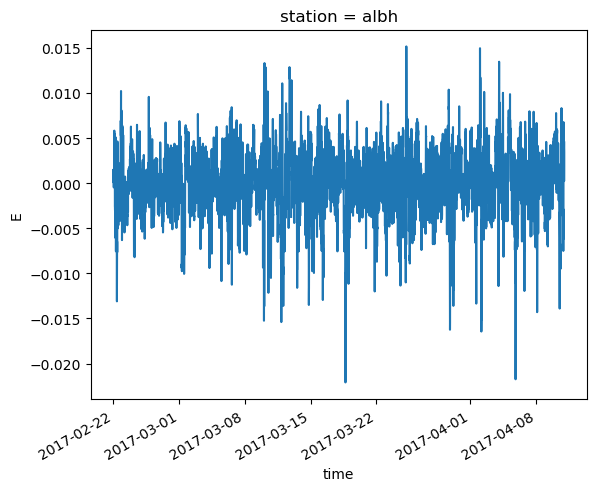

In [7]:
zarr_ds.E.plot()

In [9]:
ds_2 = xr.open_dataset("../GNSS_denoising/data/gnss_detrend_513stasv2.nc", chunks={'station': 1}).sel(station='ALBH').load()
ds_2

<xarray.Dataset>
Dimensions:    (time: 645105)
Coordinates:
    station    <U4 'ALBH'
    longitude  float64 -123.5
    latitude   float64 48.39
    elevation  float64 31.77
    depth      float64 37.48
  * time       (time) datetime64[ns] 2017-01-01 ... 2023-02-18T23:55:00
Data variables:
    e          (time) float64 -0.1325 -0.1259 -0.1235 ... -0.1683 -0.1663
    n          (time) float64 -0.13 -0.1303 -0.1269 ... -0.162 -0.1626 -0.1605
    z          (time) float64 0.02053 0.02913 0.006197 ... -0.01191 -0.005292
    sig_e(m)   (time) float64 0.007831 0.007421 0.007308 ... 0.009035 0.009022
    sig_n(m)   (time) float64 0.009445 0.00895 0.008814 ... 0.0109 0.01088
    sig_v(m)   (time) float64 0.02987 0.0283 0.02787 ... 0.03219 0.03446 0.03441
    n_detrend  (time) float64 -0.008165 -0.00847 -0.005134 ... 0.005345 0.007414
    e_detrend  (time) float64 -0.01597 -0.009353 ... -0.003475 -0.001557
    z_detrend  (time) float64 0.0336 0.0422 0.01927 ... -0.009587 -0.00297

In [10]:
ds_2 = ds_2.sel(time=slice("2017-02-15", "2017-05-01")).resample(time='10min').mean()
ds_2

<xarray.Dataset>
Dimensions:    (time: 10944)
Coordinates:
    station    <U4 'ALBH'
    longitude  float64 -123.5
    latitude   float64 48.39
    elevation  float64 31.77
    depth      float64 37.48
  * time       (time) datetime64[ns] 2017-02-15 ... 2017-05-01T23:50:00
Data variables:
    e          (time) float64 -0.1211 -0.1118 -0.1153 ... -0.126 -0.1193 -0.1141
    n          (time) float64 -0.1236 -0.1191 -0.1181 ... -0.1302 -0.1203
    z          (time) float64 -0.008058 0.007071 -0.00314 ... -0.02647 -0.03445
    sig_e(m)   (time) float64 0.006811 0.006561 0.006167 ... 0.007829 0.007907
    sig_n(m)   (time) float64 0.008214 0.007914 0.007437 ... 0.009442 0.009536
    sig_v(m)   (time) float64 0.02597 0.02503 0.02352 ... 0.02986 0.03015
    n_detrend  (time) float64 -0.000899 0.003623 0.004604 ... -0.005919 0.003948
    e_detrend  (time) float64 -0.00366 0.005704 0.002147 ... -0.0001889 0.004988
    z_detrend  (time) float64 0.004804 0.01993 0.009722 ... -0.01397 -0.02196

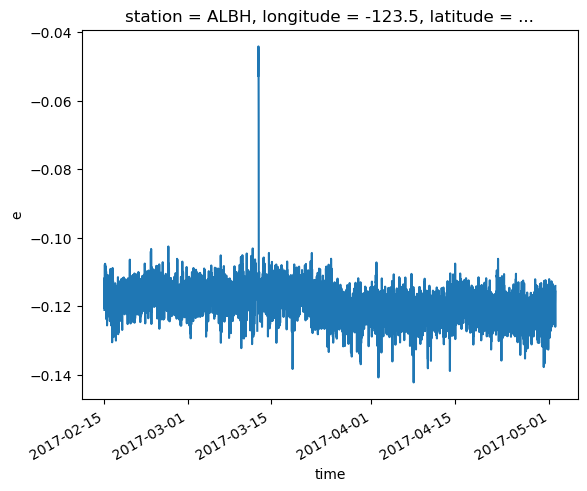

In [11]:
ds_2.e.plot()

In [27]:
ds = zarr_ds.sel(time=slice("2017-03-25T", "2017-03-26T"))
ds

<xarray.Dataset>
Dimensions:  (time: 720, station: 1)
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-03-25 2017-03-25 ... 2017-03-26T23:50:00
Data variables:
    E        (time, station) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    N        (time, station) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    PDOP     (time, station) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Z        (time, station) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

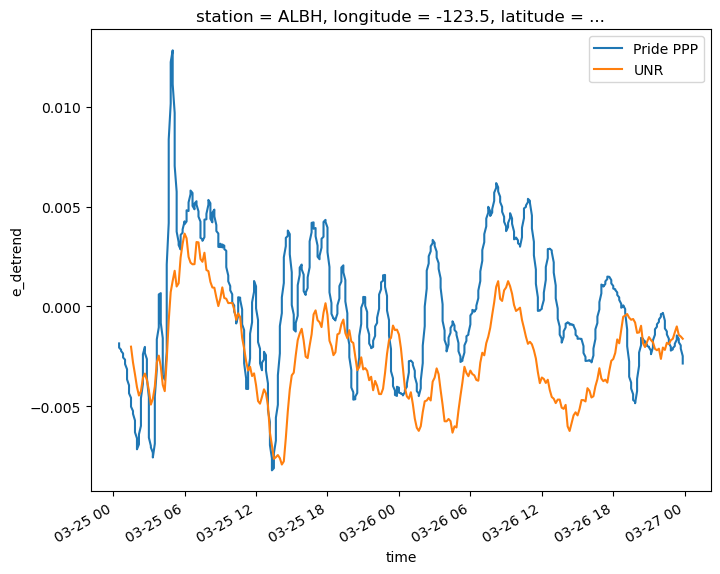

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ds.E.rolling(time=10).mean().plot(ax=ax, label="Pride PPP")
ds_2.sel(time=slice("2017-03-25T", "2017-03-26T")).e_detrend.rolling(time=10).mean().plot(ax=ax, label="UNR")
ax.legend(loc='upper right')

In [25]:
ds.E.compute()

<xarray.DataArray 'E' (time: 24, station: 1)>
array([[-1.15000000e-03],
       [-1.15000000e-03],
       [-1.15000000e-03],
       [ 9.09090909e-05],
       [ 9.09090909e-05],
       [ 9.09090909e-05],
       [-3.80000000e-03],
       [-3.80000000e-03],
       [-3.80000000e-03],
       [-1.80000000e-03],
       [-1.80000000e-03],
       [-1.80000000e-03],
       [-5.00000000e-05],
       [-5.00000000e-05],
       [-5.00000000e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-4.70000000e-03],
       [-4.70000000e-03],
       [-4.70000000e-03],
       [ 1.15000000e-03],
       [ 1.15000000e-03],
       [ 1.15000000e-03]])
Coordinates:
  * station  (station) object 'albh'
  * time     (time) datetime64[ns] 2017-03-15T23:40:00 ... 2017-03-16T00:50:00